C:\Users\User\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


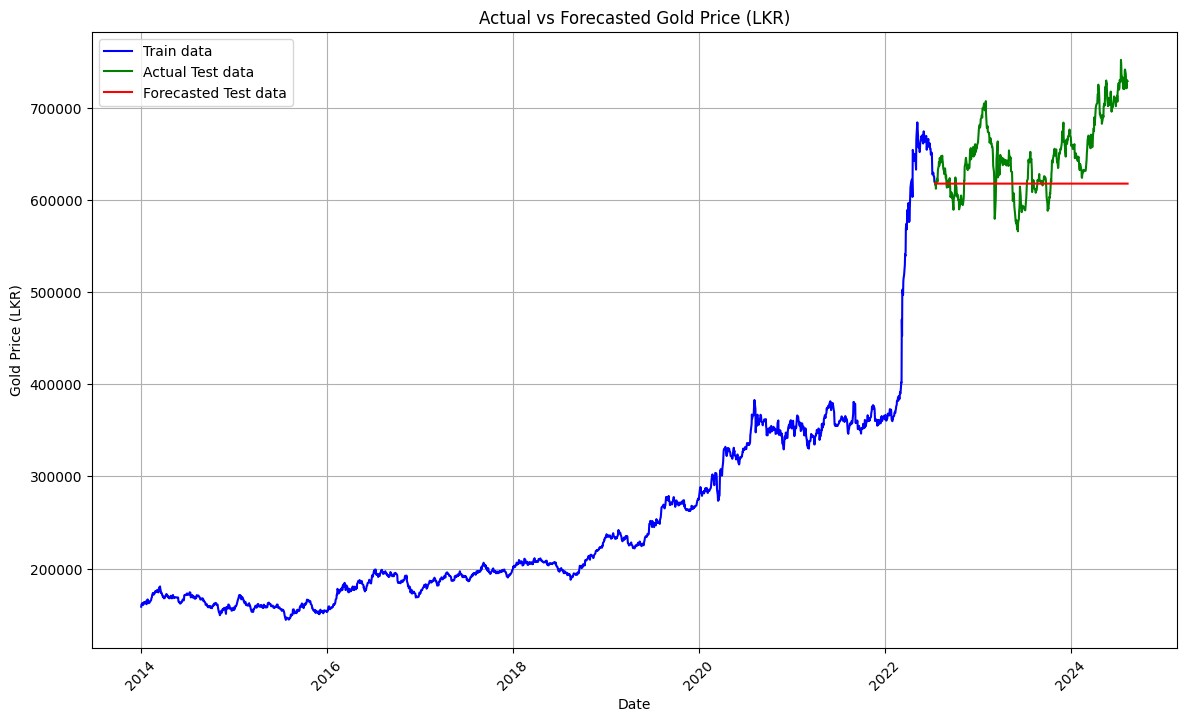

Mean Squared Error: 2747225528.622439


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select the gold price in LKR column
data = df[['date', 'gold_lkr']].set_index('date')

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Build and train the ARIMA model
model = ARIMA(train_data, order=(5, 1, 0))  # (p, d, q) values can be tuned
model_fit = model.fit()

# Forecast the test set
forecast = model_fit.forecast(steps=len(test_data))

# Plot the actual vs forecasted gold prices
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data['gold_lkr'], label="Train data", color='blue')
plt.plot(test_data.index, test_data['gold_lkr'], label="Actual Test data", color='green')
plt.plot(test_data.index, forecast, label="Forecasted Test data", color='red')
plt.xlabel("Date")
plt.ylabel("Gold Price (LKR)")
plt.title("Actual vs Forecasted Gold Price (LKR)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Calculate the mean squared error of the predictions
mse = mean_squared_error(test_data, forecast)
print(f'Mean Squared Error: {mse}')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for LSTM
window_size = 30

# Create sequences
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # 'gold_lkr' is the last column

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the model with LSTM and Attention
def create_model(n_layers, units, dropout_rate, recurrent_dropout, learning_rate):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers
    lstm_out = LSTM(units=units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout)(input_layer)
    lstm_out = BatchNormalization()(lstm_out)
    for _ in range(n_layers - 1):
        lstm_out = LSTM(units=units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout)(lstm_out)
        lstm_out = BatchNormalization()(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(units=units)(concat)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    output_layer = Dense(units=1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    units = trial.suggest_int('units', 50, 300)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    recurrent_dropout = trial.suggest_float('recurrent_dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)

    model = create_model(n_layers, units, dropout_rate, recurrent_dropout, learning_rate)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, 
                        verbose=0, callbacks=[early_stopping])
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

# Build and train the final model with the best parameters
best_n_layers = study.best_params['n_layers']
best_units = study.best_params['units']
best_dropout_rate = study.best_params['dropout_rate']
best_recurrent_dropout = study.best_params['recurrent_dropout']
best_learning_rate = study.best_params['learning_rate']

model = create_model(best_n_layers, best_units, best_dropout_rate, best_recurrent_dropout, best_learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
predictions = np.concatenate((X_test[:, -1, :-1], predictions), axis=1)
actual_values = scaler.inverse_transform(X_test_inverse)[:, -1]
predictions = scaler.inverse_transform(predictions)[:, -1]

# Calculate performance metrics
mse = mean_squared_error(actual_values, predictions)
print(f'Mean Squared Error: {mse}')

# Generate future dates
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date, periods=30, freq='B')  # Business days for 30 days

# Prepare data for future predictions
future_predictions = []
last_sequence = scaled_data[-window_size:]

for date in future_dates:
    prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_predictions.append(prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future predictions
future_predictions = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_predictions), 1)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, -1]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['date'][split+window_size:], actual_values, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predictions, label='Predicted Gold Price')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction')
plt.legend()
plt.show()


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-09-13 11:52:12,873] A new study created in memory with name: no-name-7cca0c0c-48e2-411c-a3a9-8e5c53940c73
[I 2024-09-13 11:53:38,526] Trial 0 finished with value: 0.06889776885509491 and parameters: {'n_layers': 3, 'units': 88, 'dropout_rate': 0.4900551868271418, 'recurrent_dropout': 0.3203011204782269, 'learning_rate': 0.0008755104292192996}. Best is trial 0 with value: 0.06889776885509491.
[I 2024-09-13 11:57:46,111] Trial 1 finished with value: 0.09041773527860641 and parameters: {'n_layers': 3, 'units': 127, 'dropout_rate': 0.4669852579248047, 'recurrent_dropout': 0.2503131303802473, 'learning_rate': 0.0006755995029545586}. Best is trial 0 with value: 0.06889776885509491.
[I 2024-09-13 12:03:01,531] Trial 2 finis

KeyboardInterrupt: 